In [1]:
import numpy as np
import pandas as pd
import data_colleting as dc
from sklearn.model_selection import train_test_split

In [2]:
current_datetime = pd.to_datetime('today').normalize()
instrument_1 = "SBER"
instrument_2 = "VTBR"
finam = dc.Finam(instrument_1, instrument_2)

In [3]:
sber_data, vtbr_data = finam.get_pair_data(current_datetime - pd.DateOffset(months=1), current_datetime)

ticker=SBER; period=2; start=2023/Jun/18; end=2023/Jul/18
ticker=VTBR; period=2; start=2023/Jun/18; end=2023/Jul/18


In [4]:
sber_df, vtbr_df = pd.DataFrame(data=list(map(lambda x: x.decode('utf-8').rstrip('\r\n').split(';'), sber_data[1:])),
                                        columns=sber_data[0].decode('utf-8').rstrip('\r\n').split(';')), \
    pd.DataFrame(data=list(map(lambda x: x.decode('utf-8').rstrip('\r\n').split(';'), vtbr_data[1:])), columns=vtbr_data[0].decode('utf-8').rstrip('\r\n').split(';'))

In [5]:
sber_df.rename(columns={"<DATE>": "DATE",
                          "<TIME>": "TIME",
                          "<OPEN>": "OPEN",
                          "<HIGH>":"HIGH",
                          "<LOW>": "LOW",
                          "<CLOSE>": "CLOSE",
                          "<VOL>": "VOL"}, inplace=True)
vtbr_df.rename(columns={"<DATE>": "DATE",
                          "<TIME>": "TIME",
                          "<OPEN>": "OPEN",
                          "<HIGH>":"HIGH",
                          "<LOW>": "LOW",
                          "<CLOSE>": "CLOSE",
                          "<VOL>": "VOL"}, inplace=True)

In [6]:
sber_df.head()

,<TICKER>,<PER>,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,SBER,1,20230619,100000,244.4600000,244.4700000,244.0000000,244.0000000,277910
1,SBER,1,20230619,100100,244.0000000,244.2500000,244.0000000,244.2000000,132460
2,SBER,1,20230619,100200,244.2100000,244.2300000,244.0100000,244.1000000,106340
3,SBER,1,20230619,100300,244.1100000,244.6900000,244.0300000,244.4900000,495950
4,SBER,1,20230619,100400,244.4900000,244.5000000,244.2600000,244.3000000,149880


In [6]:
sber_df, vtbr_df = sber_df.drop(['<TICKER>', '<PER>'], axis=1), vtbr_df.drop(['<TICKER>', '<PER>'], axis=1)

In [7]:
sber_df['DATETIME'], vtbr_df['DATETIME'] = pd.to_datetime(sber_df["DATE"] + sber_df['TIME']), pd.to_datetime(vtbr_df['DATE'] + vtbr_df['TIME'])

In [8]:
sber_df = sber_df.drop(['DATE', 'TIME'], axis=1)
vtbr_df = vtbr_df.drop(['DATE', 'TIME'], axis=1)

In [9]:
sber_df.iloc[:, :-1] = sber_df.iloc[:, :-1].astype(float)
vtbr_df.iloc[:, :-1] = vtbr_df.iloc[:, :-1].astype(float)

In [10]:
sber_df['AVG'] = sber_df[['OPEN', 'CLOSE']].mean(axis=1)
vtbr_df['AVG'] = vtbr_df[['OPEN', 'CLOSE']].mean(axis=1)

In [11]:
sber_df.head()

,OPEN,HIGH,LOW,CLOSE,VOL,DATETIME
0,244.46,244.47,244.0,244.0,277910.0,2023-06-19 10:00:00
1,244.0,244.25,244.0,244.2,132460.0,2023-06-19 10:01:00
2,244.21,244.23,244.01,244.1,106340.0,2023-06-19 10:02:00
3,244.11,244.69,244.03,244.49,495950.0,2023-06-19 10:03:00
4,244.49,244.5,244.26,244.3,149880.0,2023-06-19 10:04:00


In [11]:
sber_df_avg = sber_df[['AVG', 'VOL', 'DATETIME']]
vtbr_df_avg = vtbr_df[['AVG', 'VOL', 'DATETIME']]

In [12]:
df = sber_df_avg.merge(vtbr_df_avg, on='DATETIME', suffixes=['_sber', '_vtbr'])

In [13]:
df['diff'] = df['AVG_sber'] - df['AVG_vtbr']

In [14]:
df['z-score'] = (df['diff'] - df['diff'].mean()) / df['diff'].std()

In [15]:
spread_avg60 = df['z-score'].rolling(window=60, center=False).mean()
spread_avg180 = df['z-score'].rolling(window=200, center=False).mean()
spread_std180 = df['z-score'].rolling(window=200, center=False).std()
zscore_60_120 = (spread_avg60 - spread_avg180) / spread_std180

In [16]:
conditions = [(zscore_60_120 < 1.20) & (zscore_60_120 > -1.20),
              (zscore_60_120 >= 1.20),
              (zscore_60_120 <= -1.20)]
values = [0, 1, -1]

In [17]:
df_avg = df.copy()

In [18]:
df_avg['indicator'] = np.select(conditions, values)

In [54]:
conditions_nonavg = [(df['z-score'] < 1.25) & (df['z-score'] > -1.25),
              (df['z-score'] >= 1.25),
              (df['z-score'] <= -1.25)]

In [43]:
df['indicator'] = np.select(conditions_nonavg, values)

In [22]:
import matplotlib.pyplot as plt

(233.818515, 249.6870125)

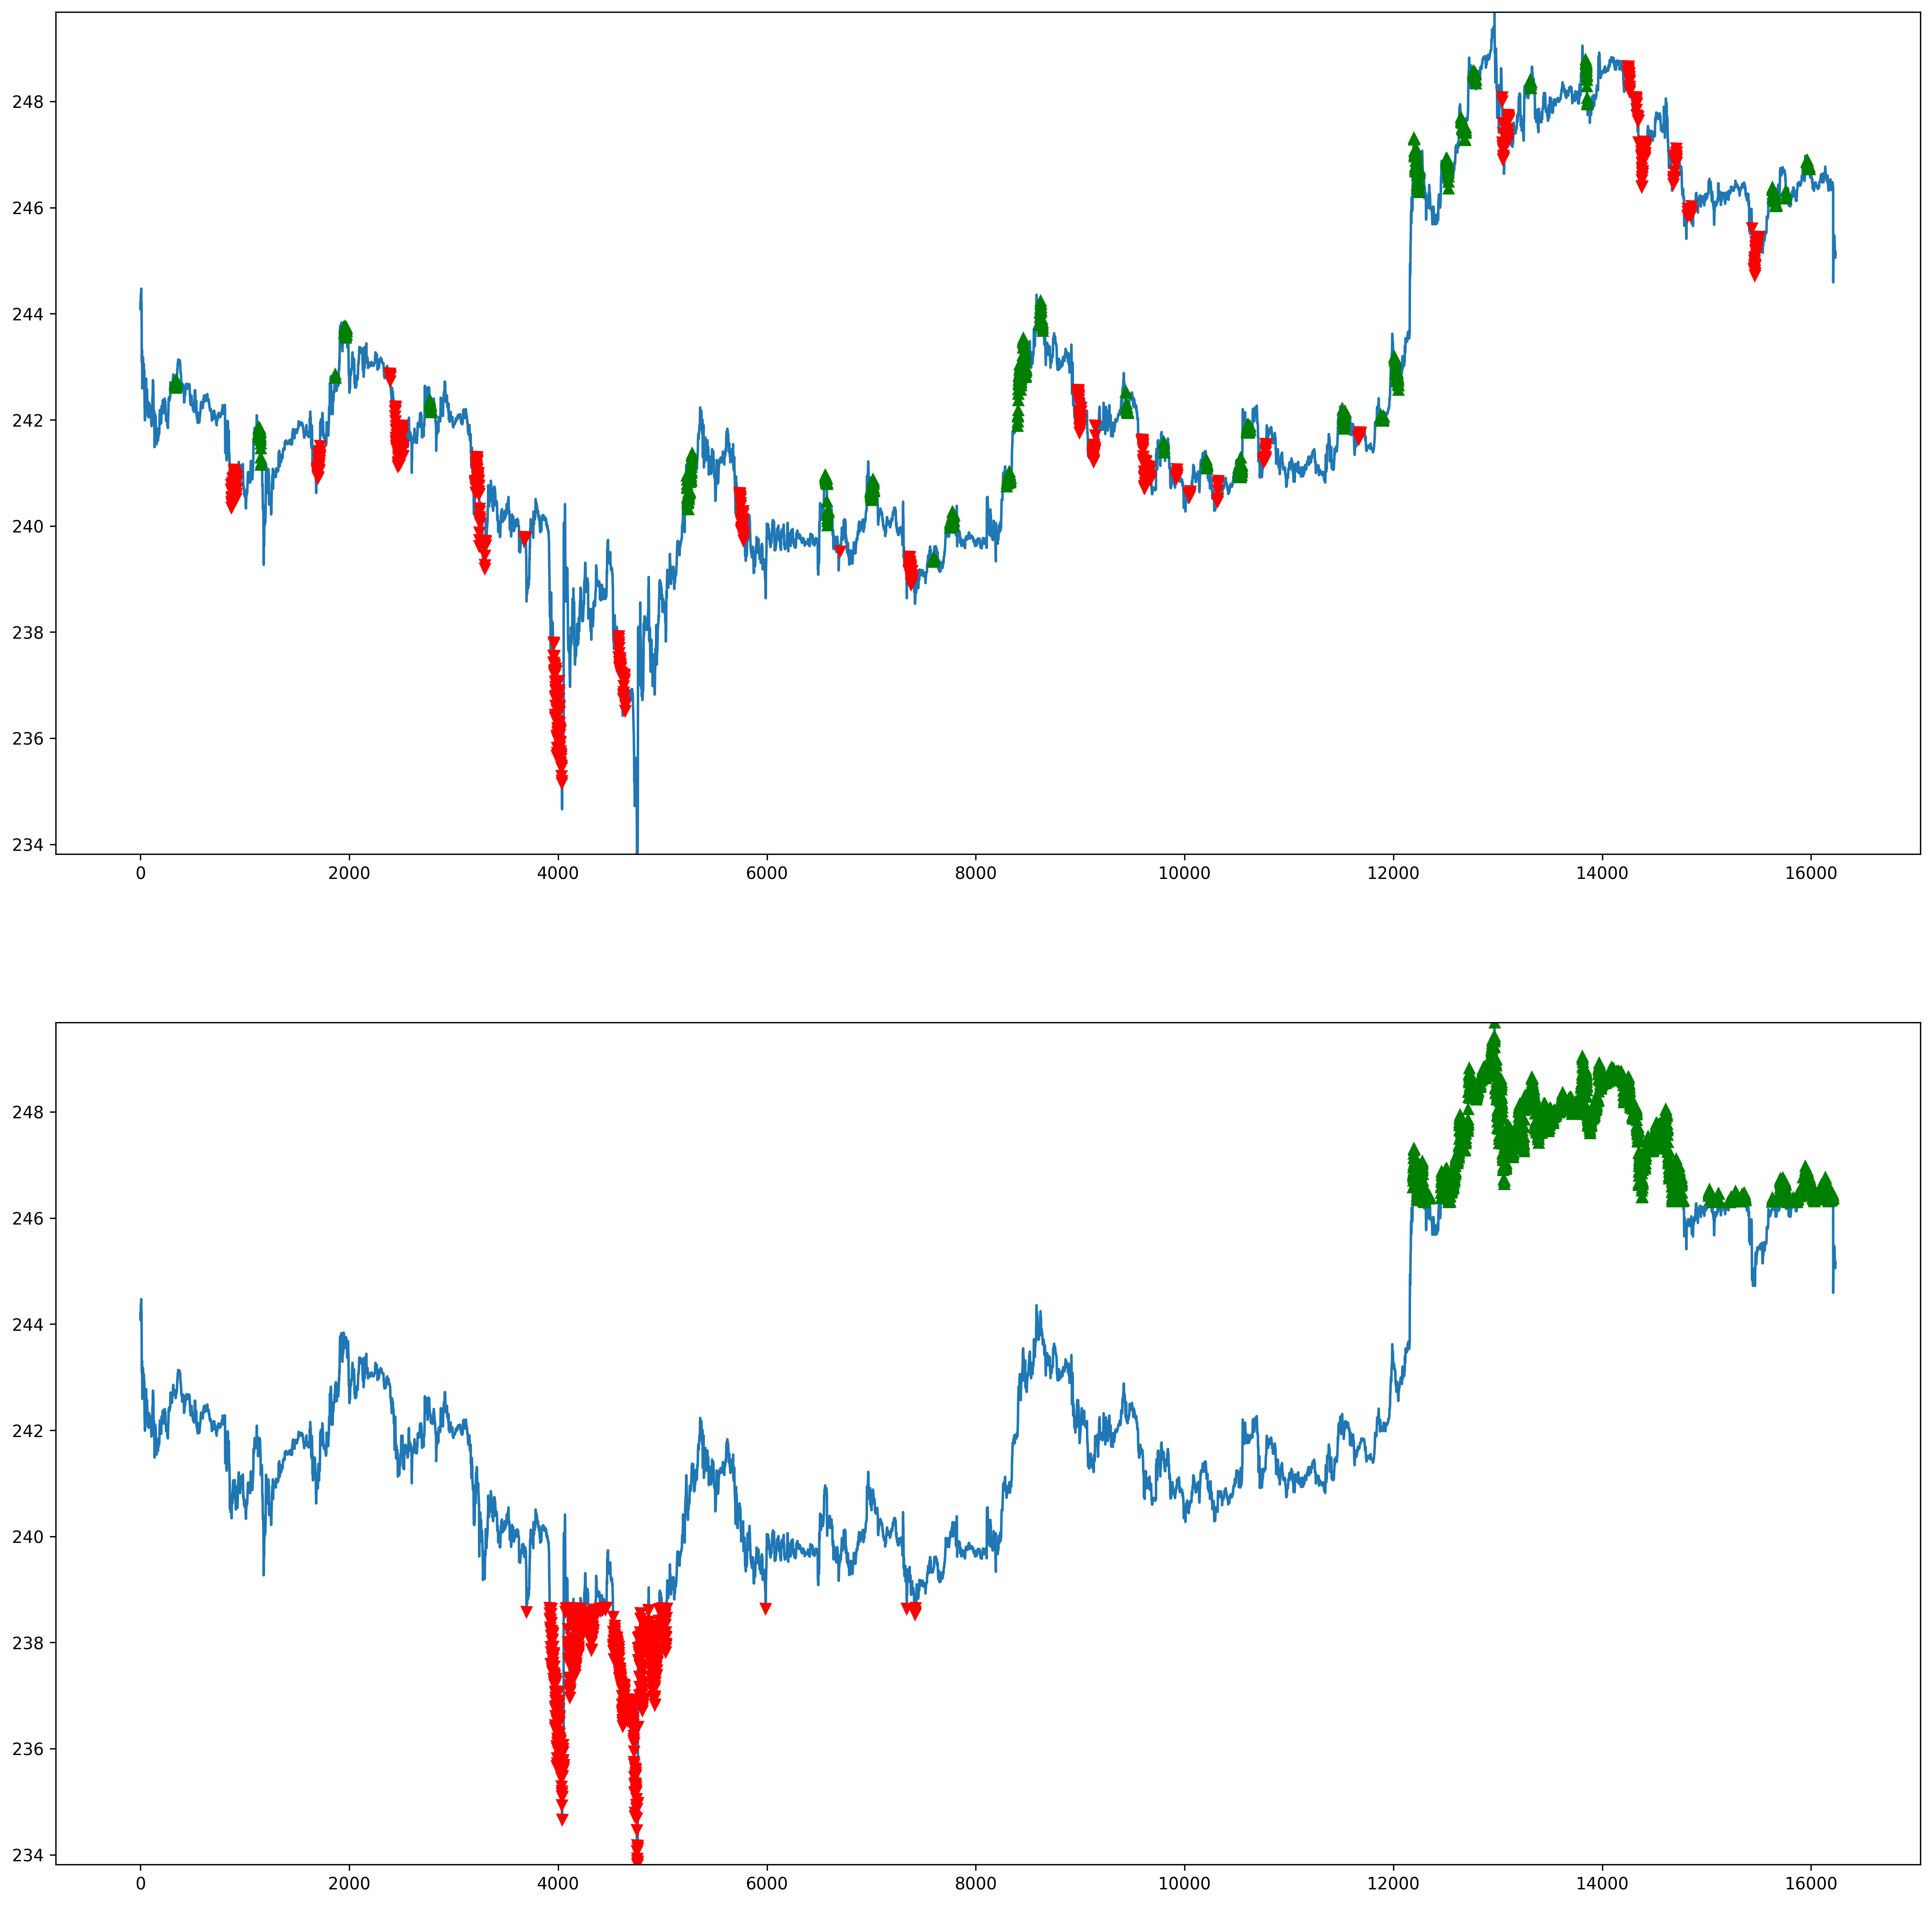

In [89]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,20,), dpi=300)
axes[0].plot(df.index, df['diff'])
axes[1].plot(df.index, df['diff'])
buy, sell = df['diff'].copy(), df['diff'].copy()
buy[df_avg['indicator'] != 1] = 0
sell[df_avg['indicator'] != -1] = 0
axes[0].plot(buy, linestyle='None', color='g', marker='^')
axes[0].plot(sell, linestyle='None', color='r', marker='v')
axes[0].set_ylim(bottom=df_avg['diff'].min(), top=df_avg['diff'].max())

buy_n, sell_n = df['diff'].copy(), df['diff'].copy()
buy_n[df['indicator'] != 1] = 0
sell_n[df['indicator'] != -1] = 0
axes[1].plot(buy_n, linestyle='None', color='g', marker='^')
axes[1].plot(sell_n, linestyle='None', color='r', marker='v')
axes[1].set_ylim(bottom=df_avg['diff'].min(), top=df_avg['diff'].max())

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_avg[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']], df_avg['indicator'], train_size=0.8, test_size=0.2, random_state=None, shuffle=False)

In [86]:
from sklearn.preprocessing import StandardScaler

In [87]:
scale = StandardScaler()
X_train[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']] = scale.fit_transform(X_train[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']])
X_test[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']] = scale.transform(X_test[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']])

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import tree
from sklearn.svm import LinearSVC

In [123]:
# Метод опорных векторов
svm = SVC(probability=True, kernel='rbf')
cv = cross_val_score(svm, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.89226823, 0.72444119, 0.89226823, 0.83950165, 0.58064516]),
 0.7858248915471814)

In [124]:
svm.fit(X_train, y_train)

SVC(probability=True)

In [127]:
y_pred = svm.predict(X_test)
y_pred[y_pred == 0]

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# Метод линейных опорных векторов
svm_linear = LinearSVC(dual='auto')
cv = cross_val_score(svm_linear, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.89226823, 0.88970319, 0.89226823, 0.89226823, 0.89186217]),
 0.8916740096863384)

In [122]:
svm_linear.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred[y_pred == -1]

array([], dtype=int32)

In [110]:
# Логистическая регрессия
lr = LogisticRegression(**{'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'})
cv = cross_val_score(lr, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.8919018 , 0.88200806, 0.89226823, 0.89226823, 0.79472141]),
 0.8706335449913979)

In [120]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[y_pred == -1]

array([], dtype=int32)

In [115]:
# K-nn
knn = KNeighborsClassifier(n_neighbors=20)
cv = cross_val_score(knn, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.8156834 , 0.64565775, 0.73946501, 0.72041041, 0.5931085 ]),
 0.702865013448472)

In [118]:
knn.fit(X_train, y_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [165]:
y_pred = knn.predict(X_test)
y_pred[y_pred == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [163]:
y_test[y_test == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [128]:
# Рандомные деревья
rfc = RandomForestClassifier(random_state=100)
cv = cross_val_score(rfc, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.72370832, 0.67204104, 0.67240748, 0.74093074, 0.42851906]),
 0.6475213278901858)

In [130]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred[y_pred == -1]

array([], dtype=int32)

In [133]:
gpc = GaussianProcessClassifier()
cv = cross_val_score(gpc, X_train, y_train, cv=3)
cv, cv.mean()

KeyboardInterrupt: 

In [132]:
# Дерево
tr = tree.DecisionTreeClassifier()
cv = cross_val_score(tr, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.70392085, 0.51557347, 0.64455845, 0.63173324, 0.36840176]),
 0.5728375523458797)

In [140]:
xb_conds = [(y_train == -1),
            (y_train == 0),
            (y_train == 1)]
xb_values = [0, 1, 2]

y_train_xb = np.select(xb_conds, xb_values)

from xgboost import XGBClassifier
xb = XGBClassifier()
cv = cross_val_score(xb, X_train, y_train_xb, cv=5)
cv, cv.mean()

(array([0.6896299 , 0.57640161, 0.71015024, 0.69329425, 0.53739003]),
 0.641373205571955)

In [142]:
xb.fit(X_train, y_train_xb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [136]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('knn', knn), ('xgb', xb)], voting='soft')

In [137]:
cv = cross_val_score(voting_clf, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.72810553, 0.61817516, 0.72077684, 0.70575302, 0.52346041]),
 0.6592541927746837)

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
def clf_performance(clf, model_name):
    print(model_name)
    print('Best Score: ' + str(clf.best_score_))
    print('Best Parameters: ' + str(clf.best_params_))

In [38]:
lr_p = LogisticRegression()
param_grid = {
    'max_iter': [2000],
    'penalty': ['l2', 'l1'],
    'C': [0.1, 1.0, 1.2589254117941673],
    'solver': ['liblinear', 'lbfgs']
}
clf_lr = GridSearchCV(lr_p, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_lr = clf_lr.fit(X_train, y_train)
clf_performance(clf_lr, "Logistic Regression")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Logistic Regression
Best Score: 0.8706335449913979
Best Parameters: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\linear_model\_

In [39]:
svm = SVC()
param_grid = [{
        'kernel': ['linear'],
    },
    {
        'kernel': ['rbf'],
        'degree': [.1, 1, 10, 100],
        'C': [.01, .1, 1., 1.25, 1.5, 2, 3]
    }]
clf_svm = GridSearchCV(svm, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_svm = clf_svm.fit(X_train, y_train)
clf_performance(best_clf_svm, "SVM")

Fitting 5 folds for each of 29 candidates, totalling 145 fits


C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 145.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\base.py", line 637, in _valida

SVM
Best Score: 0.8923336456803164
Best Parameters: {'kernel': 'linear'}


In [40]:
from sklearn import metrics

In [157]:
def metrics_model(estimator, x_test, y_test, name):
    y_pred = estimator.predict(x_test)
    print(name, 'metrics')
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("F1-score:", metrics.f1_score(y_test, y_pred, average='weighted'))
    print("Number of sells:", len(y_pred[y_pred == -1]))
    print("Number of buys:", len(y_pred[y_pred == 1]))

In [71]:
metrics_model(best_clf_svm.best_estimator_, X_test, y_test, "Linear SVM")

Linear SVM metrics
Accuracy: 0.8815943728018757
F1-score: 0.8261170945134088


In [72]:
metrics_model(best_clf_lr.best_estimator_, X_test, y_test, "Logistic Regression")

Logistic Regression metrics
Accuracy: 0.8813012895662368
F1-score: 0.8259711104580902


In [74]:
svm_linear.fit(X_train, y_train)
metrics_model(svm_linear, X_test, y_test, "Linear SVC")

Linear SVC metrics
Accuracy: 0.8813012895662368
F1-score: 0.8259711104580902


In [158]:
metrics_model(knn, X_test, y_test, "K-nearest neighbours")

K-nearest neighbours metrics
Accuracy: 0.8669402110199297
F1-score: 0.8230254551831935
Number of sells: 0
Number of buys: 83


In [151]:
y_test_conds = [
    (y_test == -1),
    (y_test == 0),
    (y_test == 1)
]
y_test = np.select(y_test_conds, xb_values)
metrics_model(xb, X_test, y_test, "XGB")

K-nearest neighbours metrics
Accuracy: 0.03253223915592028
F1-score: 0.0020500020132314233
Number of sells: 0
Number of buys: 0


In [78]:
lr = LogisticRegression(**{'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'})
svm = SVC(kernel='rbf', probability=True)
voting_clf = VotingClassifier(estimators=[('lr', lr), ('cv', svm)], voting='soft')
voting_clf.fit(X_train, y_train)
metrics_model(voting_clf, X_test, y_test, 'Ensemble')

Ensemble metrics
Accuracy: 0.8815943728018757
F1-score: 0.8261170945134088


In [79]:
from sklearn.neural_network import MLPClassifier

In [84]:
ann = MLPClassifier(hidden_layer_sizes=(200,100), solver='adam', alpha=0.1, verbose=
                    True)
ann.fit(X_train, y_train)

Iteration 1, loss = 0.49136122
Iteration 2, loss = 0.40010065
Iteration 3, loss = 0.39196331
Iteration 4, loss = 0.38610211
Iteration 5, loss = 0.37985582
Iteration 6, loss = 0.37671422
Iteration 7, loss = 0.37421788
Iteration 8, loss = 0.37112357
Iteration 9, loss = 0.36918785
Iteration 10, loss = 0.36702384
Iteration 11, loss = 0.36417207
Iteration 12, loss = 0.36311561
Iteration 13, loss = 0.36108472
Iteration 14, loss = 0.35923188
Iteration 15, loss = 0.36051301
Iteration 16, loss = 0.35692963
Iteration 17, loss = 0.35763318
Iteration 18, loss = 0.35648093
Iteration 19, loss = 0.35446161
Iteration 20, loss = 0.35346949
Iteration 21, loss = 0.35196892
Iteration 22, loss = 0.35196299
Iteration 23, loss = 0.35109501
Iteration 24, loss = 0.35016613
Iteration 25, loss = 0.34935908
Iteration 26, loss = 0.34860504
Iteration 27, loss = 0.34725179
Iteration 28, loss = 0.34679255
Iteration 29, loss = 0.34672087
Iteration 30, loss = 0.34619455
Iteration 31, loss = 0.34473574
Iteration 32, los

C:\Users\ivkpo\PycharmProjects\z-indicators\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(alpha=0.1, hidden_layer_sizes=(200, 100), verbose=True)